# Fisheries Employment

Visualizing employment in the fishing sector as a proportion of total employmnet in Natural Sectors (agriculture, forestry, and hunting)

*Author: Rachel Thoms
<br>Created: 24 Aug 2021
<br>Environment: jupyterlab*

## Style

- Vega chart
- Chart type: stacked bar
- Value: enumber of people employed

## Data

- Data: [com_037_rw0_fishing_employment_edit](https://resourcewatch.carto.com/u/wri-rw/dataset/com_037_rw0_fishing_employment_edit)
- Source: [ILO](https://ilostat.ilo.org/data/#)

## Preparation

### Vega

In [1]:
import json
from vega import Vega
from IPython.display import display

In [2]:
def Vega(spec):
    bundle = {}
    bundle['application/vnd.vega.v5+json'] = spec
    display(bundle, raw=True)

In [3]:
widget_width = 800
widget_height = 300

## Visualization

The ILO provides employment data collected classified according to the International Standard Industrial Classification (ISIC). Here we use two different "levels" of economic activity. ISIC Level 2 is a more detailed version of the groups in Level 1. Each level is provided as a dataset. Each dataset contains data collected by two revisios of the ISIC classification system- ISIC Revisions 3.1 (before 2007) and 4 (after 2007). More info [here](https://archive.unescwa.org/sites/www.unescwa.org/files/events/files/event_detail_id_681_tablesbtwnisicrev.pdf).

At classfiication Level 1, in the 3rd revolution of the classifciation system (Rev 3.1) the Natural Sector Economic Activity was split into two classifications:
'A. Agriculture, hunting and forestry' [ECO_ISIC3_A] & 'B. Fishing' [ECO_ISIC3_B]. These will need to be combined. In the 4th revolition of the classifcation system 
(Rev 4) the Natural Sector Economic Activity is aggregated into one classification: A. Agriculture; forestry and fishing [ECO_ISIC4_A]

At classification Level 2, in Rev 3.1 Fishing Economic Activity is classified as '05 - Fishing, aquaculture and service activities incidental to fishing' 
[EC2_ISIC3_B05]. In Rev 4 Fishing Economic Activity is classified as '03 - Fishing and aquaculture' [EC2_ISIC4_A03].

For the purpose of this widget, we want to use data collected *only* according to the most recent classification system. This will avoid changes in values that are a reflection of a change in methodolgy/classification as opposed to an actual change in employment. Therefore, we draw Rev 4 data where available. If a country does not have any employment data using the Rev 4 classficiation system, we draw on their records collected using Rev 3.

### Queries

#### Testing

```gadm.geostore_prod ILIKE 'ca5bfde08587530e76c17fe48362a01d'``` used as stand-in for parameterized ```{{{geostore_env}}='{{geostore_id}}'``` in production version

```sql
-- entries for countries where data was collected using rev 4
SELECT rev,  gadm.gid_0 AS gid_0, gadm.name_0 AS name_0, CONCAT(data.type, ' ', data.sex) AS variable, data.year AS date, data.obs_value AS value, data.unit AS unit 
    FROM (SELECT area, year, rev, obs_value, concat(type, ' Employment ') AS type, sex, '1000 people' AS unit 
        FROM com_037_rw0_fishing_employment_edit 
    WHERE obs_value IS NOT NULL AND rev = 4) data 
    LEFT JOIN (SELECT DISTINCT(gid_0), name_0, geostore_prod FROM gadm36_0) AS gadm ON data.area = gadm.gid_0 WHERE gadm.geostore_prod ILIKE 'ca5bfde08587530e76c17fe48362a01d' 
UNION 
-- entries for countries where there is no data for rev 4 (in this case we pull data on the most recent classificiation - rev 3)
SELECT rev, gadm.gid_0 AS gid_0, gadm.name_0 AS name_0, CONCAT(data.type, ' ', data.sex) AS variable, data.year AS date, data.obs_value AS value, data.unit AS unit 
    FROM (SELECT area, year, obs_value, rev, concat(type, ' Employment ') AS type, sex, '1000 people' AS unit 
        FROM com_037_rw0_fishing_employment_edit WHERE obs_value IS NOT NULL) data
LEFT JOIN (SELECT DISTINCT(area), obs_value as rev4 FROM com_037_rw0_fishing_employment_edit WHERE obs_value IS NOT NULL AND rev = 4) rev4 ON rev4.area = data.area 
LEFT JOIN (SELECT DISTINCT(gid_0), name_0, geostore_prod FROM gadm36_0) AS gadm ON data.area = gadm.gid_0 WHERE gadm.geostore_prod ILIKE 'ca5bfde08587530e76c17fe48362a01d' AND rev4.rev4 IS NULL
ORDER BY date ASC, variable ASC


```

#### Parameterized

```sql
SELECT rev, gadm.gid_0 AS gid_0, gadm.name_0 AS name_0, CONCAT(data.type, ' ', data.sex) AS variable, data.year AS date, data.obs_value AS value, data.unit AS unit FROM (SELECT area, year, obs_value, rev, concat(type, ' Employment ') AS type, sex, '1000 people' AS unit FROM com_037_rw0_fishing_employment_edit WHERE obs_value IS NOT NULL) data LEFT JOIN (SELECT DISTINCT(area), obs_value as rev4 FROM com_037_rw0_fishing_employment_edit WHERE obs_value IS NOT NULL AND rev = 4) rev4 ON rev4.area = data.area LEFT JOIN (SELECT DISTINCT(gid_0), name_0, geostore_prod FROM gadm36_0) AS gadm ON data.area = gadm.gid_0 WHERE gadm.{{geostore_env}} ILIKE '{{geostore_id}}' AND rev4.rev4 IS NULL UNION SELECT rev,  gadm.gid_0 AS gid_0, gadm.name_0 AS name_0, CONCAT(data.type, ' ', data.sex) AS variable, data.year AS date, data.obs_value AS value, data.unit AS unit FROM (SELECT area, year, rev, obs_value, concat(type, ' Employment ') AS type, sex, '1000 people' AS unit FROM com_037_rw0_fishing_employment_edit WHERE obs_value IS NOT NULL AND rev = 4) data LEFT JOIN (SELECT DISTINCT(gid_0), name_0, geostore_prod FROM gadm36_0) AS gadm ON data.area = gadm.gid_0 WHERE gadm.{{geostore_env}} ILIKE '{{geostore_id}}' ORDER BY date ASC, variable ASC 
```

In [4]:
spec=json.loads("""{
  "$schema": "https://vega.github.io/schema/vega/v5.json",
  "description": "A searchable, stacked area chart of U.S. occupations from 1850 to 2000.",
  "padding": 5,
  "signals": [
    {
      "name": "sex",
      "value": "Total",
      "bind": {"input": "select", "options": ["Total", "Male", "Female"]}
    }
  ],
  "data": [
    {
      "name": "table",
      "url": "https://wri-rw.carto.com/api/v2/sql?q=SELECT rev, gadm.gid_0 AS gid_0, gadm.name_0 AS name_0, CONCAT(data.type, ' ', data.sex) AS variable, data.year AS date, data.obs_value AS value, data.unit AS unit FROM (SELECT area, year, obs_value, rev, concat(type, ' Employment ') AS type, sex, '1000 people' AS unit FROM com_037_rw0_fishing_employment_edit WHERE obs_value IS NOT NULL) data LEFT JOIN (SELECT DISTINCT(area), obs_value as rev4 FROM com_037_rw0_fishing_employment_edit WHERE obs_value IS NOT NULL AND rev = 4) rev4 ON rev4.area = data.area LEFT JOIN (SELECT DISTINCT(gid_0), name_0, geostore_prod FROM gadm36_0) AS gadm ON data.area = gadm.gid_0 WHERE gadm.{{geostore_env}} ILIKE '{{geostore_id}}' AND rev4.rev4 IS NULL UNION SELECT rev,  gadm.gid_0 AS gid_0, gadm.name_0 AS name_0, CONCAT(data.type, ' ', data.sex) AS variable, data.year AS date, data.obs_value AS value, data.unit AS unit FROM (SELECT area, year, rev, obs_value, concat(type, ' Employment ') AS type, sex, '1000 people' AS unit FROM com_037_rw0_fishing_employment_edit WHERE obs_value IS NOT NULL AND rev = 4) data LEFT JOIN (SELECT DISTINCT(gid_0), name_0, geostore_prod FROM gadm36_0) AS gadm ON data.area = gadm.gid_0 WHERE gadm.{{geostore_env}} ILIKE '{{geostore_id}}' ORDER BY date ASC, variable ASC ",
      "format": {"type": "json", "property": "rows"},
      "transform": [
        {"type": "stack", "field": "value", "groupby": ["gid_0", "date"]},
        {
          "type": "formula",
          "expr": "split(datum.variable, ' Employment')[0]",
          "as": "sector"
        },
        {
          "type": "formula",
          "expr": "split(datum.variable, '_')[1]",
          "as": "sex"
        },
        {"type": "formula", "expr": "datum.value*1000", "as": "value"},
        {
          "type": "formula",
          "expr": "replace(datum.sector, ' ', '_')",
          "as": "sector"
        },
        {
          "type": "formula",
          "expr": "replace(datum.sector, ' ', '_')",
          "as": "sector"
        },
        {
          "type": "pivot",
          "groupby": ["gid_0", "date", "sex"],
          "field": "sector",
          "value": "value"
        },
        {
          "type": "formula",
          "expr": "datum.Fishing > datum.Natural_Sector_Total ? null: datum.Natural_Sector_Total",
          "as": "Natural_Sector_Total"
        },
        {
          "type": "formula",
          "expr": "datum.Fishing ? datum.Natural_Sector_Total - datum.Fishing: datum.Natural_Sector_Total",
          "as": "Other Natural Sectors"
        },
        {
          "type": "fold",
          "fields": ["Fishing", "Other Natural Sectors"],
          "as": ["sector", "value"]
        },
        {"type": "filter", "expr": "isValid(datum.Natural_Sector_Total)"},
        {
          "type": "stack",
          "field": "value",
          "groupby": ["date", "sex"],
          "sort": {
            "field": ["gid_0", "date", "sector"],
            "order": ["descending", "ascending", "descending"]
          }
        }
      ]
    },
    {
      "name": "filter",
      "source": "table",
      "transform": [
        {
          "type": "formula",
          "expr": "test(/M/, datum.sex) ? 'Male': test(/F/, datum.sex) ? 'Female' : 'Total'",
          "as": "sex"
        },
        {"type": "filter", "expr": "datum.sex==sex"}
      ]
    }
  ],
  "scales": [
    {
      "name": "x",
      "type": "band",
      "range": "width",
      "domain": {"data": "filter", "field": "date"}
    },
    {
      "name": "y",
      "type": "linear",
      "range": "height",
      "nice": true,
      "zero": true,
      "domain": {"data": "table", "field": "y1"}
    },
    {
      "name": "color",
      "type": "ordinal",
      "range": ["#84c0d0", "#f3b229"],
      "domain": {"data": "filter", "field": "sector"}
    },
      {
      "name": "legend",
      "type": "ordinal",
      "range": ["#84c0d0", "#f3b229"],
      "domain": ["Fishing", "Other Natural Sectors/ (Agriculture, Forestry, /and Hunting)"]
    }
  ],
  "axes": [
    {
      "orient": "bottom",
      "scale": "x",
      "zindex": 1,
      "labelFontSize": 11,
      "labelOverlap": true
    },
    {
      "orient": "left",
      "scale": "y",
      "zindex": 0,
      "title": "Number of people",
      "titlePadding": 8,
      "titleFontSize": 12,
      "titleFont": "Lato",
      "labelBaseline": "middle",
      "labelAlign": "right",
      "labelPadding": 8,
      "ticks": true,
      "tickSize": 5,
      "grid": true,
      "gridOpacity": 0.2,
      "encode": {
        "labels": {"update": {"text": {"signal": "format(datum.value, ',')"}}}
      }
    }
  ],
  "marks": [
    {
      "type": "rect",
      "from": {"data": "filter"},
      "encode": {
        "enter": {
          "x": {"scale": "x", "field": "date"},
          "width": {"scale": "x", "band": 1, "offset": -1},
          "y": {"scale": "y", "field": "y0"},
          "y2": {"scale": "y", "field": "y1"},
          "fill": {"scale": "color", "field": "sector"}},
        "update": {
          "fillOpacity": [
            {
              "test": "test(/Other Natural Sectors/, datum.sector)",
              "value": 0.8
            },
            {"value": 1}
          ]
        },
        "hover": {"fillOpacity": {"value": 0.5}}
      }
    }
  ],
  "legends": [
    {
      "title": ["Sector:"], 
      "fill": "legend", 
      "orient": "right",
      "labelFont": "Lato",
      "titleFont": "Lato",
      "encode": {
      "labels": {
        "update": {
        "lineBreak": {"value": "/"}
        }}
      }
      }
    ],
   "interaction_config": [
    {
      "name": "tooltip",
      "config": {
        "fields": [
          {
            "column": "name_0",
            "property": "Country",
            "type": "string",
            "format": ""
          },
          {
            "column": "sector",
            "property": "Sector",
            "type": "string",
            "format": ""
          },
          {
            "column": "value",
            "property": "Number of people employed",
            "type": "number",
            "format": ""
          }
        ]
      }
    }
  ]
}""")


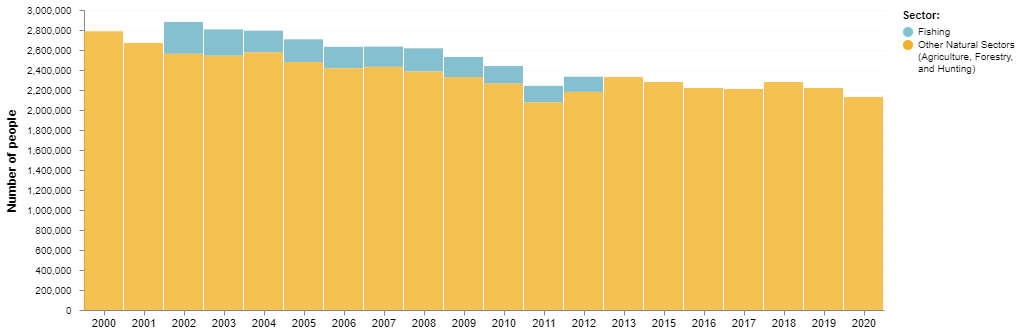

In [5]:
vega_view=dict(spec)

## DEFINE SIZE
vega_view['height'] = widget_height
vega_view['width'] = widget_width

## PARAMETERIZE WIDGET
vega_view['data'][0]['url']= vega_view['data'][0]['url'].replace('{{geostore_env}}','geostore_prod')
vega_view['data'][0]['url'] = vega_view['data'][0]['url'].replace('{{geostore_id}}','ca5bfde08587530e76c17fe48362a01d')

## ADJUST X AXIS
vega_view['axes'][0]['labelBaseline']= "top"

## FONT
vega_view['axes'][1]['titleFont'] = 'Arial'
vega_view['legends'][0]['labelFont'] = 'Arial'
vega_view['legends'][0]['titleFont'] = 'Arial'

Vega(vega_view)


[Open the Chart in the Vega Editor](https://vega.github.io/editor/#/url/vega/N4IgJAzgxgFgpgWwIYgFwhgF0wBwqgegIDc4BzJAOjIEtMYBXAI0poHsDp5kTykSArJQBWENgDsQAGhAATONABONHJnaT0AQQAEEOEkWwkTADZwpuzEigBrOLO0H92o4sza2AM20BVSgGVKDygoBhwkNQkIbU9FNgRtAEYADgEABm1MNm0AJjT8ymkQAHcaWXo0ZPyZeBoyLDQAZmqQcNlZGnEyNAEZCDrxJBMINABtUEGEODQQPQAPIuIhhmn0ABU2KxMipk7ZNFBOnAZMGb0zKFOZNlV1EdRRkA2tooBZIemZADFED5AAXQAvoD-jJZBEUA8JkgpjMrKZPiAGIptugsLh8ERisoALSKYqUKAGLKE+IEJA4GgkHKcACOJgA-LSALz+ACiABk2QBhNbaCiyBDUMoAfTSFgFQsmcDFFnBmHM2iWymMZgsSxMKwsDHEdG0XwASgB5V4eYoi0qyMhwTAihWKZRZRQAT20mn82nlSG0XK+fKNPjWbIN2gAUkaAJIAOX5SEFjQAbGLY4LtEaY17hbJk8yU0LaNmMgB1AASwbZeeocDYECdMpwcQcEY5EYA0hWAOREgRMTzyNKpZIAdgEzTgQ4TUESQ88cAALMlEzkkGlErIO26owARbSW63uXMdzw0CAwTpkbSIHAmNjOqbiTAbo0GrfB7QAIQAmp6InA3f5uXVAwaFVP93W5bQik8NhFGQU5UFATBnRwVYQFECQigbG44DcZ0ZjiYoRkBGRMEUJBxAgaDYLGRDkNQ2trBsKCaDgEx9nQDUViKMg4jCJg8IeEACzFIp5WmIEpFolCZiohAGBMFAZDgOYGzOa86AACnlBghWVECEQsDc2QQa9b3vR8AEpRjSf4iiQe5ZjgS4YJAYipNQ2T5MUkBlNU9AIHUzAtIiHTKD00DDJFDsrMSWyZHss5lNcySQCQ6T0E8hSil8xQZm03TljgAAqRJ8jSOyHM46Y3NSuiZJguSsqUlTcvQRQ4Gvaw4GCzBQr0ZzFEM7QO0i6KKsSgbkvc+rYK87KWvwjqFKgbr8sofqnSGkbhqiizxv8pynSm2r0taGhiE2bjeJwfixiE0VyrBX8inmAEZGPVj2McyaZCqmY-pqtKPIaubmr8uQQqFL4TzPLptAAPh-XqhSjEKyJMEV-EOmCRWeIZtAZbRxHkkxUCR0LUd69HMexxRcc2IZ9pASnkSGGmBvpl5AbqjKQaanyFvQNbodPc8CfJlG0bZrGObxkxtBxCXKBF2GyDJtaWepmWnU5xn4oco16Bw7RNfx7WYKIlKgfqtjmM++5HhV88ikN+BFBNqX5fNxQRlBEAEsEjaXN+wqAW507jxMe15vBk8ADUhjKHqKc99mdblvbw-oqxbDt22ONDmQeLYPiBMeMSXqSv2xDcA4QA+-PHmEx6IYVSvJr9mD5Fa8uFBW8QOi6Cr+8H7owT7uAB+doEQRq6UZJoKOcJekvDFQ+EzCKUjyMohqaJO4HZv5nK4QUIKCFeAg5Uh9blIs8WO3eMwOzJhVaw0ggvivpX5nvwmOx+MgZ+2gyYdjlh2Jmr0s4LyXrlMGrVW59WUsyZkUCgTVyJGYB20JYToAWCRHmIAmDkX2DIMiXRUKWgqGCeISBOh1y9DA6O70WL51btVOeMJUJ4QIadEwnR9BwJAOQ60Mxaj1CuCAXUK00CkS1CAAAXjhNgsjFDyNkLQ+hCFW6QlSqBPOX1nSJFcpw3BIAoBsBvEI626Au6dD1sI8iojBIAGJkhzigGkWQLcXGeEaEwHIOQACcb05CaI0KARhGVF7MPrqwr6QdcrAj9kgOYCh94wRYg+GYTBNhZAQC9TBqF8GKL2ElVAiQZAKSYKxL4Eh4IgE0CqbYVTjC1Pqf4GgSi0CJEqSAaprEjSkBRBSVRKwaqZMng0swnhJHQD+OgHhpSB7lPFKlOgm90BRh0jU92XhtAoRuJvEiGy4AAAU4yj0qCczAZg6kPk6d0ipORWk1JMPchpTSQItP6W0kw757KsQETMBAZRZDHN+W8zQ-CyAaGEXUBorzWIXPaM7VAyQTm2HuHI8w6zbCPNWL0ISyh2I4qLiSo04QoB0AEmkSgLyfLiAsfIOuAzhh1zCBXbRCo5jwVAP0WFjNeawQiMnAqmpFQjTGsCGVftkCKBsNgg+i1LhQTiAU7RUS4mwOSoy5lqxQBTOXtohY2j5mbJACUhuX0K7ERKGUCoZqikzBKcQgePTrieE8HoeCOJEh2oEvy51iyDEzGdOVANOQ67mu4aGxZxi7WR1REGhZ5jLHBziZ9CaR07VZEsWoHA0aBhCpAMADsn5BEvyVmJQyxlTJ3imboWmVaxW3wGtoFBh5XbG1Nl7WmEANz-00DxGgoQo7Ij-AAMn1DBM+LoNzqxvokiytaTI3gbQ+UBZNZKirWlVQyUhKACEUNFQEJiZCcuetopNlLrA0v3m-Bpj6P7dvdr27Q3sIDfzWsuxYodUB0uSDVP6FTZ41DYMMuuN6qX3u0SBulAgZUgiqeQSesglVqFuasR43t0B+yTTMCxViiiTOyW1BFpxZ5AA)

# Indicator

Percentage of the workforce that is female 

## Rank

```sql
SELECT CONCAT(rank, ' of ', max_rank) AS value FROM (SELECT *, MAX(rank) OVER (PARTITION BY true) AS max_rank FROM(SELECT 
    *, RANK() OVER(ORDER BY ratio DESC) as rank
FROM (
            SELECT 
                area, 
                RANK() OVER(PARTITION BY area ORDER BY year DESC) as yr_rank,  
                SUM(CASE 
                  WHEN sex = 'SEX_F' THEN obs_value
                    ELSE 0
                  END)/NULLIF(SUM(CASE
                  WHEN sex = 'SEX_T' THEN obs_value
                  ELSE 0
                  END),0)*100 AS ratio
            FROM com_037_rw0_fishing_employment_edit 
            WHERE type = 'Fishing' 
            GROUP BY area, year
            ) data  
LEFT JOIN gadm36_0 gadm on gadm.gid_0 = data.area 
WHERE yr_rank =1 AND coastal=true AND ratio IS NOT NULL) ranked ) max_rank
WHERE geostore_prod ILIKE 'ca5bfde08587530e76c17fe48362a01d' 
```

#### Raw
`https://wri-rw.carto.com/api/v2/sql?q=SELECT CONCAT(rank, ' of ', max_rank) AS value FROM (SELECT *, MAX(rank) OVER (PARTITION BY true) AS max_rank FROM(SELECT *, RANK() OVER(ORDER BY ratio DESC) as rank FROM (SELECT area, RANK() OVER(PARTITION BY area ORDER BY year DESC) as yr_rank, SUM(CASE WHEN sex = 'SEX_F' THEN obs_value ELSE 0 END)/NULLIF(SUM(CASE WHEN sex = 'SEX_T' THEN obs_value ELSE 0 END),0)*100 AS ratio FROM com_037_rw0_fishing_employment_edit WHERE type = 'Fishing' GROUP BY area, year) data  LEFT JOIN gadm36_0 gadm on gadm.gid_0 = data.area WHERE yr_rank =1 AND coastal=true AND ratio IS NOT NULL) ranked ) max_rank WHERE {{geostore_env}} ILIKE '{{geostore_id}}'`

#### [Demo](https://wri-rw.carto.com/api/v2/sql?q=SELECT%20CONCAT(rank,%20%27%20of%20%27,%20max_rank)%20AS%20value%20FROM%20(SELECT%20*,%20MAX(rank)%20OVER%20(PARTITION%20BY%20true)%20AS%20max_rank%20FROM(SELECT%20*,%20RANK()%20OVER(ORDER%20BY%20ratio%20DESC)%20as%20rank%20FROM%20(SELECT%20area,%20RANK()%20OVER(PARTITION%20BY%20area%20ORDER%20BY%20year%20DESC)%20as%20yr_rank,%20SUM(CASE%20WHEN%20sex%20=%20%27SEX_F%27%20THEN%20obs_value%20ELSE%200%20END)/NULLIF(SUM(CASE%20WHEN%20sex%20=%20%27SEX_T%27%20THEN%20obs_value%20ELSE%200%20END),0)*100%20AS%20ratio%20FROM%20com_037_rw0_fishing_employment_edit%20WHERE%20type%20=%20%27Fishing%27%20GROUP%20BY%20area,%20year)%20data%20%20LEFT%20JOIN%20gadm36_0%20gadm%20on%20gadm.gid_0%20=%20data.area%20WHERE%20yr_rank%20=1%20AND%20coastal=true%20AND%20ratio%20IS%20NOT%20NULL)%20ranked%20)%20max_rank%20WHERE%20geostore_prod%20ILIKE%20%27ca5bfde08587530e76c17fe48362a01d%27)

## Value

``` sql
SELECT 
    ROUND(female_employment/NULLIF(total_employment,0)*100) AS value
FROM (
    SELECT 
        area, 
        year,  
        SUM(CASE 
            WHEN sex = 'SEX_F' THEN obs_value
            ELSE 0
            END) female_employment,
        SUM(CASE
            WHEN sex = 'SEX_T' THEN obs_value
            ELSE 0
            END) total_employment,
        RANK() OVER(PARTITION BY area ORDER BY year DESC) as yr_rank 
    FROM com_037_rw0_fishing_employment_edit 
    WHERE type = 'Fishing' 
    GROUP BY area, year 
) data
LEFT JOIN gadm36_0 gadm on gadm.gid_0 = data.area
WHERE yr_rank = 1 AND gadm.{{geostore_env}} ILIKE '{{geostore_id}}'
```

query: [`https://wri-rw.carto.com/api/v2/sql?q=SELECT ROUND(female_employment/NULLIF(total_employment,0)*100) AS value FROM (SELECT area, year, SUM(CASE WHEN sex = 'SEX_F' THEN obs_value ELSE 0 END) female_employment, SUM(CASE WHEN sex = 'SEX_T' THEN obs_value ELSE 0 END) total_employment, RANK() OVER(PARTITION BY area ORDER BY year DESC) as yr_rank FROM com_037_rw0_fishing_employment_edit WHERE type = 'Fishing' GROUP BY area, year ) data
LEFT JOIN gadm36_0 gadm on gadm.gid_0 = data.area WHERE yr_rank = 1 AND gadm.{{geostore_env}} ILIKE '{{geostore_id}}'`](https://wri-rw.carto.com/api/v2/sql?q=SELECT%20ROUND(female_employment/NULLIF(total_employment,0)*100)%20AS%20value%20FROM%20(SELECT%20area,%20year,%20SUM(CASE%20WHEN%20sex%20=%20%27SEX_F%27%20THEN%20obs_value%20ELSE%200%20END)%20female_employment,%20SUM(CASE%20WHEN%20sex%20=%20%27SEX_T%27%20THEN%20obs_value%20ELSE%200%20END)%20total_employment,%20RANK()%20OVER(PARTITION%20BY%20area%20ORDER%20BY%20year%20DESC)%20as%20yr_rank%20FROM%20com_037_rw0_fishing_employment_edit%20WHERE%20type%20=%20%27Fishing%27%20GROUP%20BY%20area,%20year%20)%20data%20LEFT%20JOIN%20gadm36_0%20gadm%20on%20gadm.gid_0%20=%20data.area%20WHERE%20yr_rank%20=%201%20AND%20gadm.gid_0%20ILIKE%20%27MEX%27)

## RW Backoffice

- [back office](https://resourcewatch.org/admin/data/widgets/49e474c1-014b-476c-b832-8c9a556ad6e3/edit?dataset=4487e012-9571-4175-991a-101268d6bb3f)
- parent dataset [com.037.rw0](https://resourcewatch.org/data/explore/4487e012-9571-4175-991a-101268d6bb3f) (unpublished)
- dataset id ```4487e012-9571-4175-991a-101268d6bb3f```
- widget id: ```49e474c1-014b-476c-b832-8c9a556ad6e3```